In [1]:
import random,os,glob,time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchinfo import summary
from torch import nn
from torchvision import transforms
from torch.utils.data import (Dataset, DataLoader)
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plotter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 2   
    EPOCHS = 15 
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count()))
  #  BATCH_SIZE = 4
    LR = 0.001   
    APPLY_SHUFFLE = True
    SEED = 2024
    HEIGHT = 256
    WIDTH = 256
    CHANNELS = 3
    IMAGE_SIZE = (256, 256, 3)

In [3]:
TRAIN_PATH = Path("/kaggle/input/gender-recognizer/dataset")
IMAGE_PATH_LIST = list(TRAIN_PATH.glob("*/*.jpg"))
print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 1195


In [4]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = img_path
    labels[i] = img_path.parent.stem
    
dataset_df = pd.DataFrame({'image_path':images_path, 
                                  'label':labels})

dataset_df.head()

image_path label
0  /kaggle/input/gender-recognizer/dataset/MEN/20...   MEN
1  /kaggle/input/gender-recognizer/dataset/MEN/20...   MEN
2  /kaggle/input/gender-recognizer/dataset/MEN/20...   MEN
3  /kaggle/input/gender-recognizer/dataset/MEN/20...   MEN
4  /kaggle/input/gender-recognizer/dataset/MEN/20...   MEN

In [6]:
def _load(image_path, as_tensor=True):

    image = Image.open(image_path)
    
    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

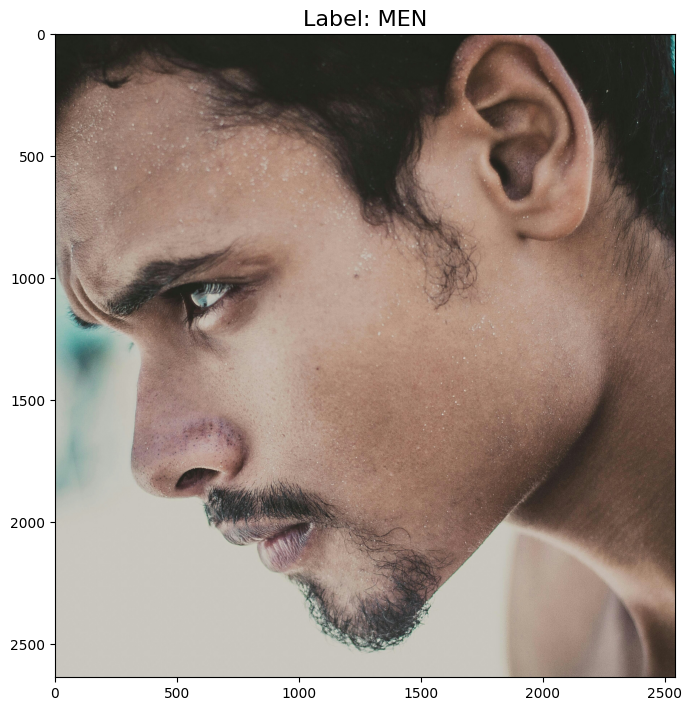

In [7]:
idx = random.sample(dataset_df.index.to_list(), 1)[0]

sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

view_sample(sample_image.permute(1, 2, 0), sample_label)

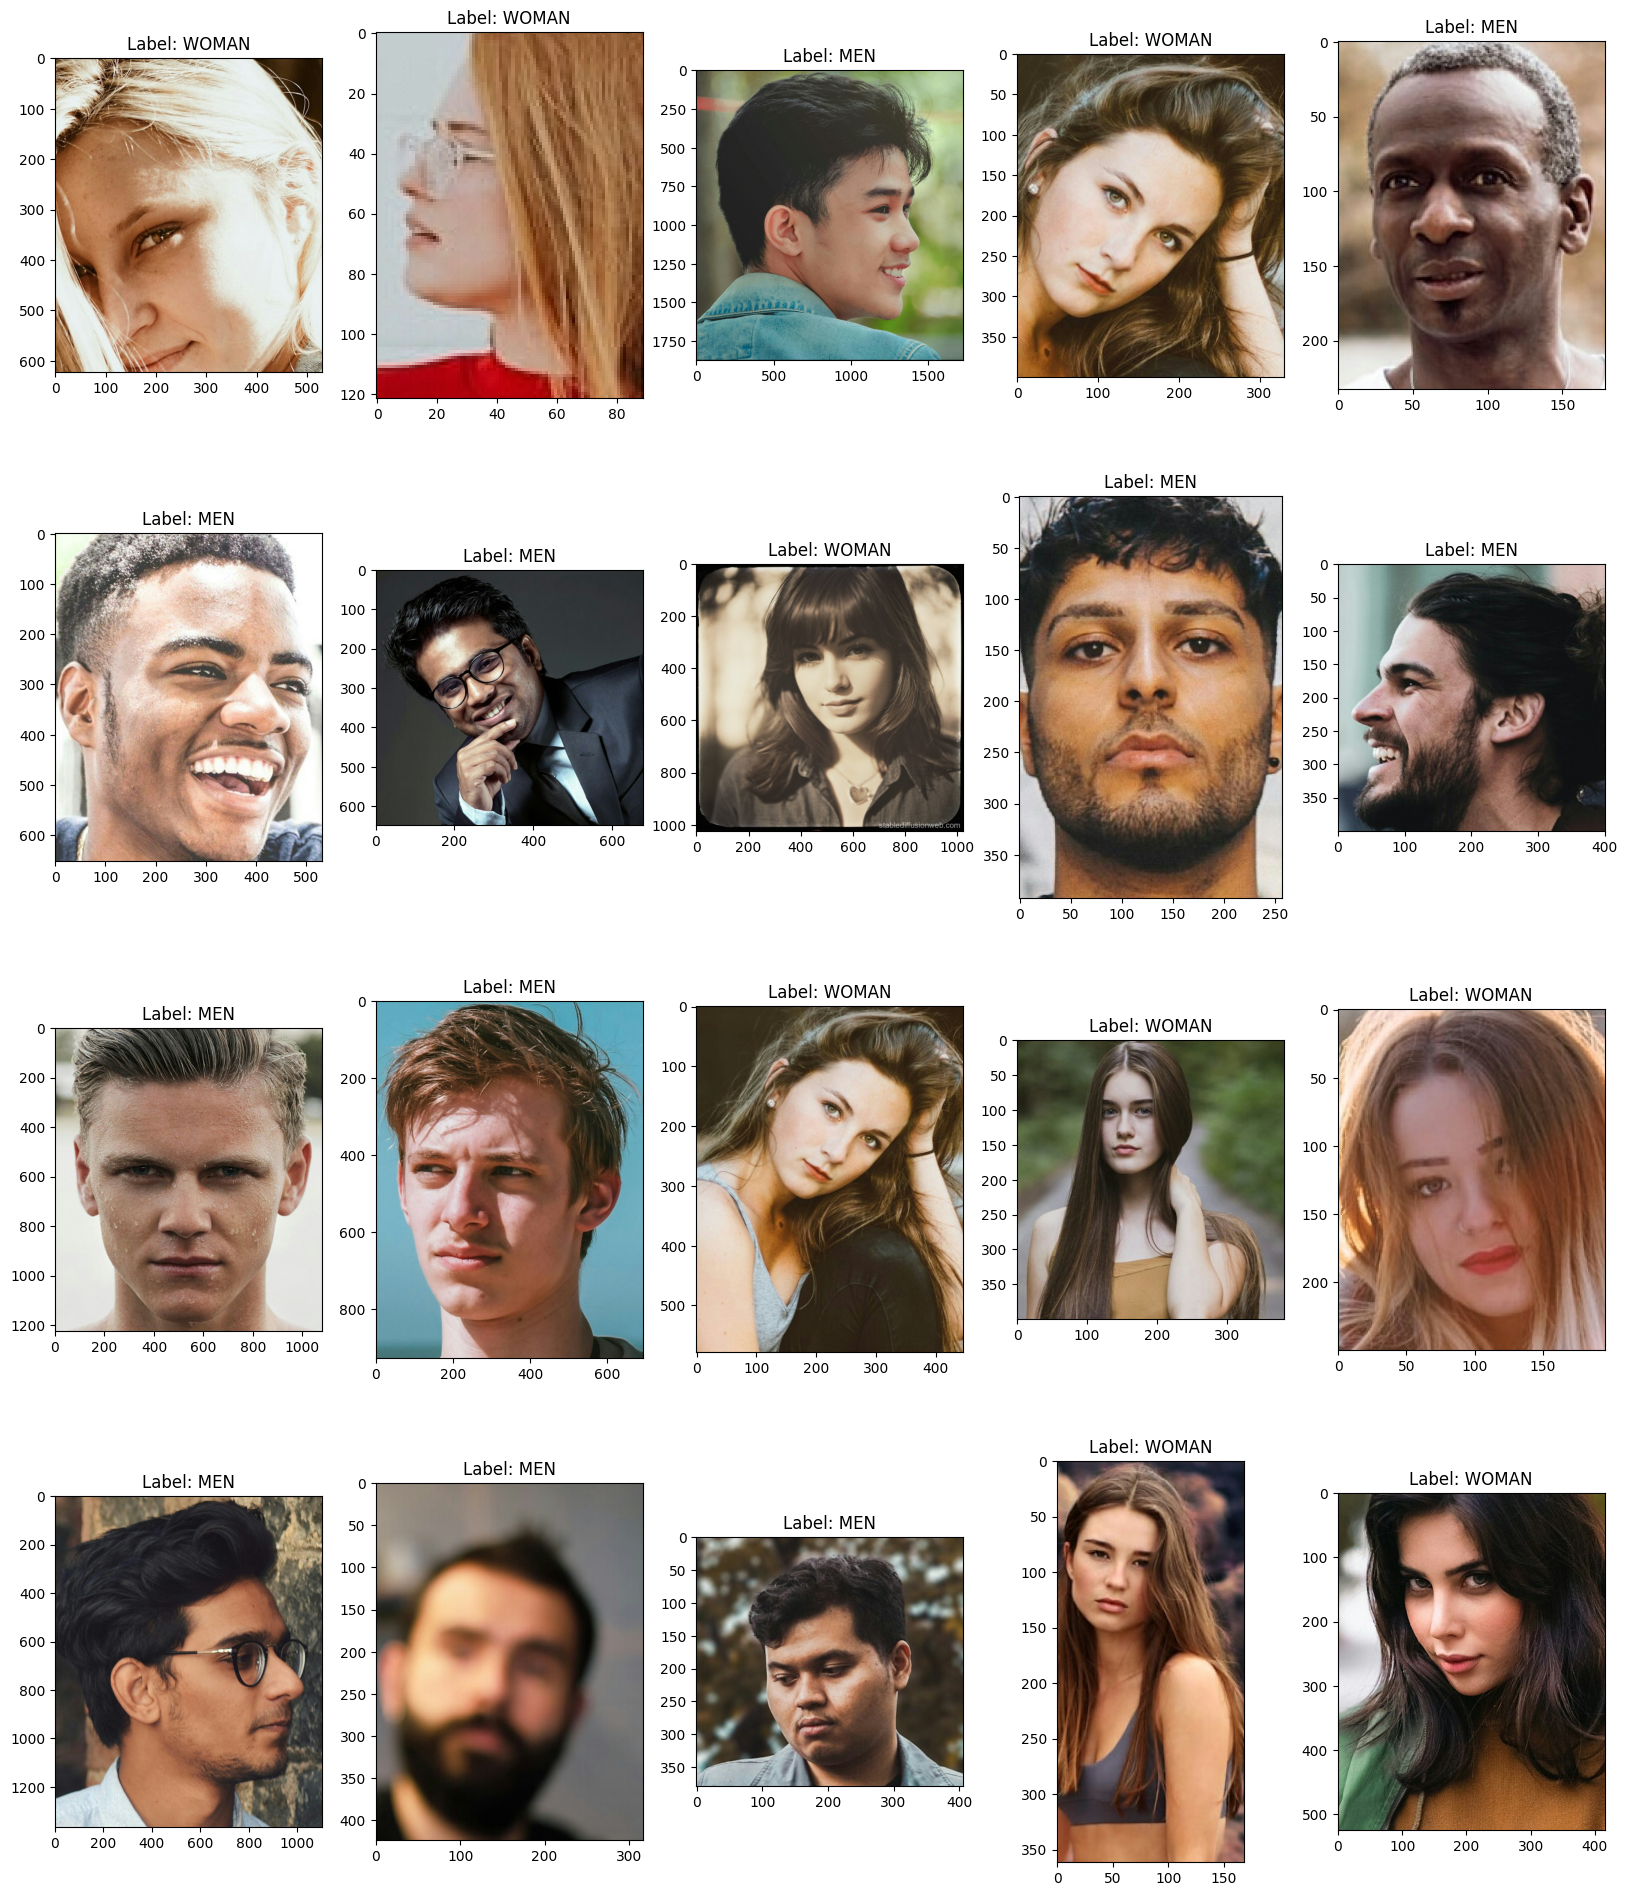

In [8]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)
    
    return

view_mulitiple_samples(
    dataset_df, _load, 
    count=20, fig_size=(20, 24)  
)

In [9]:
 
train_split_idx, temp_split_idx, _, _ = (
    train_test_split(
        dataset_df.index, 
        dataset_df.label, 
        test_size=0.30,
        stratify=dataset_df.label,
        random_state=CFG.SEED
    )
)

In [10]:
train_df = dataset_df.iloc[train_split_idx].reset_index(drop=True)
temp_df = dataset_df.iloc[temp_split_idx].reset_index(drop=True)
train_df.shape, temp_df.shape

((836, 2), (359, 2))

In [11]:
val_split_idx, test_split_idx, _, _ = (
    train_test_split(
        temp_df.index, 
        temp_df.label, 
        test_size=0.5,
        stratify=temp_df.label,
        random_state=CFG.SEED
    )
)

In [12]:
val_df = temp_df.iloc[val_split_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_split_idx].reset_index(drop=True)
val_df.shape, test_df.shape

((179, 2), (180, 2))

In [13]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'Total:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		836	(69.96%)
validation samples count:	179	(14.98%)
test samples count:		180	(15.06%)
Total:				1195	(100.00%)


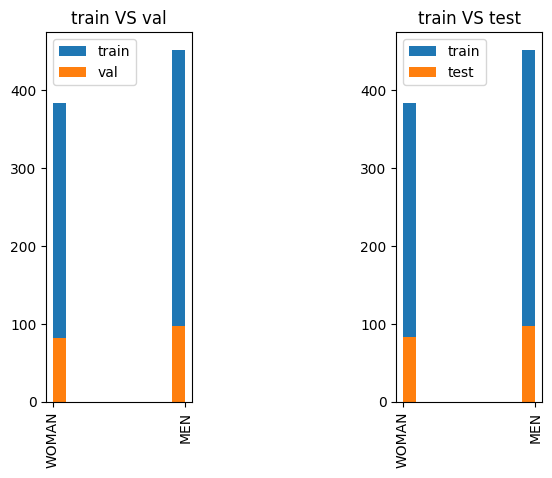

In [15]:
plt.subplot(1, 3, 1)
plt.hist(train_df["label"], label='train');
plt.hist(val_df["label"], label='val');
plt.legend();
plotter.xticks(rotation = 90);
plt.title('train VS val');

plt.subplot(1, 3, 3)
plt.hist(train_df["label"], label='train');
plt.hist(test_df["label"], label='test');
plt.legend();
plotter.xticks(rotation = 90);
plt.title('train VS test');

In [16]:
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.ToTensor()
])

In [17]:
idx = random.sample(dataset_df.index.to_list(), 1)[0]
aug_image = _load(dataset_df.image_path[idx], as_tensor=False)

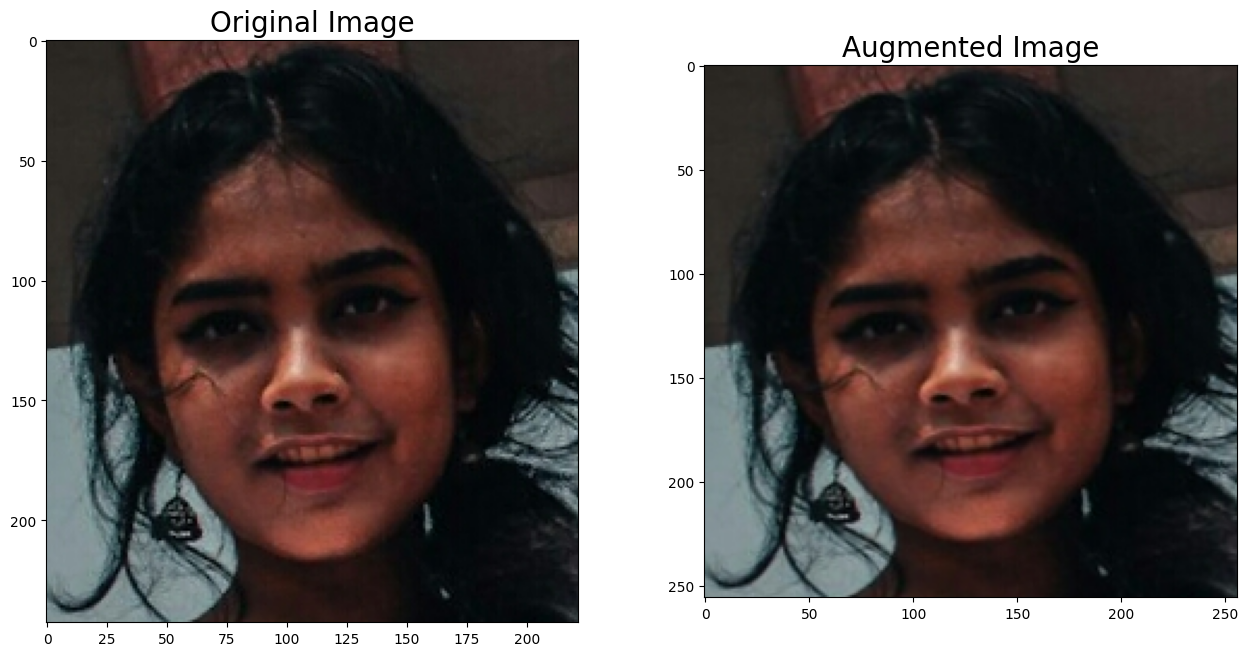

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
fig.tight_layout(pad=6.0)
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image);
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0));

In [19]:
class GRDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [20]:
train_ds = GRDataset(train_df, transform=train_transforms)
val_ds = GRDataset(val_df, transform=test_transforms)
test_ds = GRDataset(test_df, transform=test_transforms)

In [21]:
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

val_loader = DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=(not CFG.APPLY_SHUFFLE)
)

test_loader = DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=(not CFG.APPLY_SHUFFLE)
)

In [22]:
def build_model(device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

 
    model_weights = (
        torchvision
        .models
        .EfficientNet_B0_Weights
        .DEFAULT
    )
    
    
    model = (
        torchvision.models.efficientnet_b0(
            weights=model_weights
        )
    ).to(device) 
    
  
    for param in model.features.parameters():
        param.requires_grad = False
    
    
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.2, inplace=True), 
        nn.Linear(
            in_features=1280, out_features=CFG.NUM_CLASSES,bias=True
        )
    ).to(device)
    
    return model

In [23]:

efficientnet_B0 = build_model(device=CFG.DEVICE)
efficientnet_B0 = nn.DataParallel(efficientnet_B0)

summary(
    model=efficientnet_B0, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 58.4MB/s]


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
DataParallel (DataParallel)                                       [32, 3, 256, 256]    [32, 2]              --                   Partial
├─EfficientNet (module)                                           [32, 3, 256, 256]    [32, 2]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 16, 128, 128]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 128, 128]   [32, 24, 64, 64]     (16,714)             False
│    │    └─Sequential (3)                     

In [24]:
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

optimizer = torch.optim.Adam(
    efficientnet_B0.parameters(),
    lr=CFG.LR
)

In [25]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
   
    model.train()
    
    train_loss, train_acc = 0, 0
    

    for batch, (X, y) in enumerate(tqdm(dataloader)):
        
        X, y = X.to(device), y.to(device)
        
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        
        optimizer.zero_grad()
        loss.backward()
        
        
        optimizer.step()
        
        
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [26]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    
    model.eval()
    
    
    eval_loss, eval_acc = 0, 0
    
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)

            
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

In [27]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }
    
    
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )     
               
        
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
        
        
    return session

In [28]:
print('Training EfficientNet Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : efficientnet_B0,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

session_history = train(**session_config)

Training EfficientNet Model
Train on 836 samples, validate on 179 samples.
----------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.5307 - acc: 0.7940 - eval_loss: 0.4061 - eval_acc: 0.9375

Epoch 2/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3707 - acc: 0.9225 - eval_loss: 0.3431 - eval_acc: 0.9444

Epoch 3/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3412 - acc: 0.9282 - eval_loss: 0.3244 - eval_acc: 0.9391

Epoch 4/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3159 - acc: 0.9433 - eval_loss: 0.3151 - eval_acc: 0.9444

Epoch 5/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3384 - acc: 0.9306 - eval_loss: 0.3204 - eval_acc: 0.9444

Epoch 6/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3586 - acc: 0.8947 - eval_loss: 0.3138 - eval_acc: 0.9531

Epoch 7/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3154 - acc: 0.9468 - eval_loss: 0.3046 - eval_acc: 0.9391

Epoch 8/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3269 - acc: 0.9259 - eval_loss: 0.3045 - eval_acc: 0.9339

Epoch 9/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3060 - acc: 0.9433 - eval_loss: 0.3053 - eval_acc: 0.9339

Epoch 10/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3105 - acc: 0.9410 - eval_loss: 0.2990 - eval_acc: 0.9339

Epoch 11/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3302 - acc: 0.9306 - eval_loss: 0.3048 - eval_acc: 0.9391

Epoch 12/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.2941 - acc: 0.9676 - eval_loss: 0.3118 - eval_acc: 0.9391

Epoch 13/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3097 - acc: 0.9456 - eval_loss: 0.3006 - eval_acc: 0.9391

Epoch 14/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.2978 - acc: 0.9606 - eval_loss: 0.3021 - eval_acc: 0.9339

Epoch 15/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3120 - acc: 0.9410 - eval_loss: 0.3014 - eval_acc: 0.9479


In [29]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
   
    model.eval()
    
    predictions = []
    
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            
            X, y = X.to(device), y.to(device)

            
            y_pred = model(X) 

           
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [30]:
test_probs = predict(efficientnet_B0, test_loader, CFG.DEVICE)
test_preds = np.argmax(test_probs, axis=1)
test_preds

  0%|          | 0/6 [00:00<?, ?it/s]

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1])

In [31]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuaracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return

In [32]:
session_history_df = pd.DataFrame(session_history)
session_history_df

loss  accuracy  eval_loss  eval_accuaracy
0   0.530663  0.793981   0.406067        0.937500
1   0.370669  0.922454   0.343066        0.944353
2   0.341191  0.928241   0.324363        0.939145
3   0.315929  0.943287   0.315103        0.944353
4   0.338418  0.930556   0.320405        0.944353
5   0.358594  0.894676   0.313821        0.953125
6   0.315418  0.946759   0.304558        0.939145
7   0.326937  0.925926   0.304483        0.933936
8   0.305950  0.943287   0.305343        0.933936
9   0.310474  0.940972   0.298991        0.933936
10  0.330180  0.930556   0.304798        0.939145
11  0.294086  0.967593   0.311783        0.939145
12  0.309652  0.945602   0.300581        0.939145
13  0.297840  0.960648   0.302128        0.933936
14  0.311987  0.940972   0.301378        0.947917

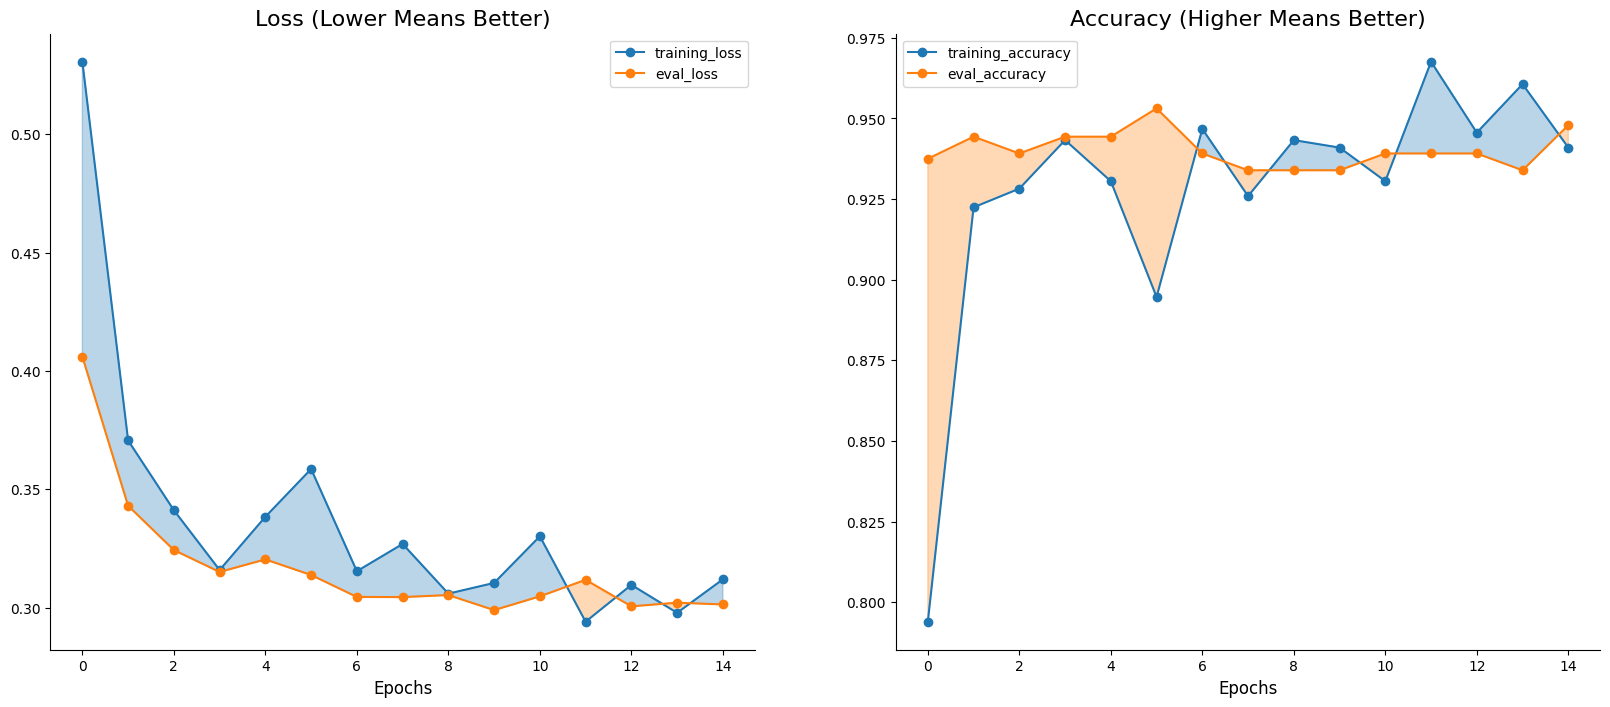

In [33]:
plot_training_curves(session_history)

In [34]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    
    cm = confusion_matrix(y_true, y_pred)
    
 
    plt.figure(figsize=figsize)

    
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
   
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    
    plt.show()
    
    return

In [35]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

Accuracy is: 92.778%


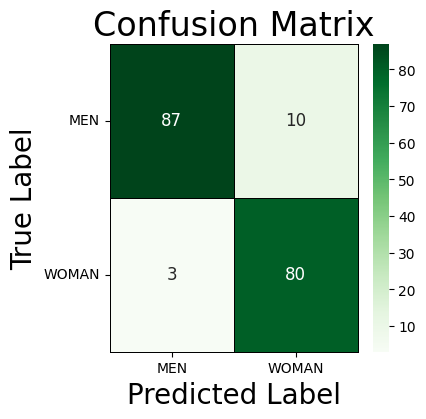

In [36]:
accuracy = accuracy_score(test_labels, test_preds)
print("Accuracy is: {0:.3f}%".format(accuracy * 100))

plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(4, 4),  
    classes=test_ds.classes)

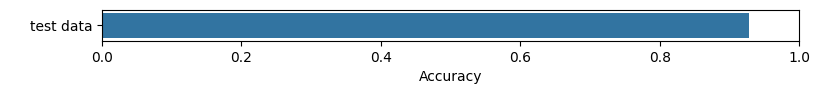

In [37]:

Visualization_models = [('test data', accuracy)]                                          
Visualization_predict = pd.DataFrame(data = Visualization_models, columns=[' ', 'Accuracy'])
f, axe = plt.subplots(1,1, figsize=(9,0.4))
Visualization_predict.sort_values(by=['Accuracy'], ascending=False, inplace=True)
sns.barplot(x='Accuracy', y=' ',  data = Visualization_predict, ax = axe)
axe.set_xlabel('Accuracy', size=10)
axe.set_ylabel(' ', size=10)
axe.set_xlim(0,1.0)
plt.show()

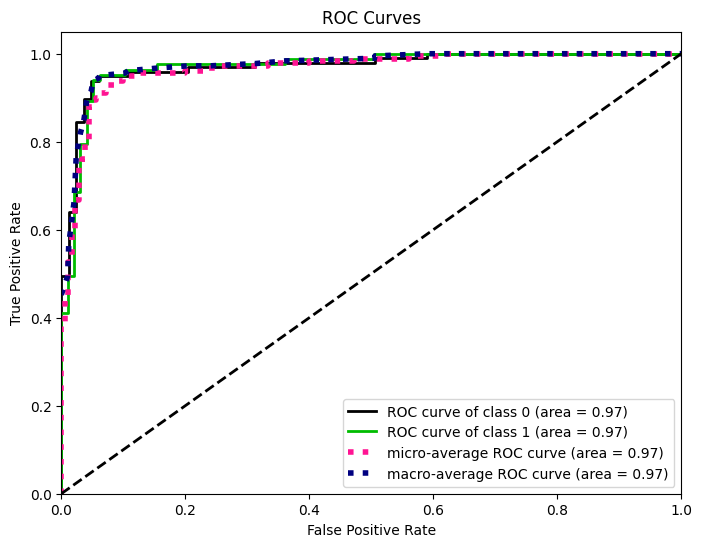

In [38]:
plot_roc(
    test_labels, 
    test_probs, 
    figsize=(8, 6), title_fontsize='large'
);

In [39]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

         MEN       0.97      0.90      0.93        97
       WOMAN       0.89      0.96      0.92        83

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180



In [40]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [41]:
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)


Performance Metrics:

accuracy_score:		0.9278

_____________________________________________
precision_score:	0.9308

_____________________________________________
recall_score:		0.9278

_____________________________________________
f1_score:		0.9279

_____________________________________________
matthews_corrcoef:	0.8582



In [42]:
results_df0 = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
})

submission0=results_df0

submission0.to_csv('results_df0.csv', index=False)
submission0

image_path  label  label_encoded  \
0    /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
1    /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
2    /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
3    /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
4    /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
..                                                 ...    ...            ...   
175  /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
176  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
177  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
178  /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
179  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   

     model_prediction  
0                   1  
1                   1  
2                   0  
3                   0  
4                   0  
..                ...  
175                 0  
176                 1  
177                 1  
178                 0  
179                 1  

[180 rows x 4 columns]